## Customer Churn Analysis

IMPORTING THE REQUIRED LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import  ADASYN
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score
import pickle

In [2]:
df=pd.read_csv("Telco_customer_churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
df.shape

(7043, 21)

In [4]:
df.columns.values

array(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
       'TotalCharges', 'Churn'], dtype=object)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [6]:
# printing the unique values in all the columns

numerical_features_list = ["tenure", "MonthlyCharges", "TotalCharges"]

for col in df.columns:
  if col not in numerical_features_list:
    print(col, df[col].unique())
    print("-"*50)

customerID ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
--------------------------------------------------
gender ['Female' 'Male']
--------------------------------------------------
SeniorCitizen [0 1]
--------------------------------------------------
Partner ['Yes' 'No']
--------------------------------------------------
Dependents ['No' 'Yes']
--------------------------------------------------
PhoneService ['No' 'Yes']
--------------------------------------------------
MultipleLines ['No phone service' 'No' 'Yes']
--------------------------------------------------
InternetService ['DSL' 'Fiber optic' 'No']
--------------------------------------------------
OnlineSecurity ['No' 'Yes' 'No internet service']
--------------------------------------------------
OnlineBackup ['Yes' 'No' 'No internet service']
--------------------------------------------------
DeviceProtection ['No' 'Yes' 'No internet service']
---------------------------------------

In [7]:
print(df.isnull().sum())

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [8]:
df['Churn'].value_counts()

Churn
No     5174
Yes    1869
Name: count, dtype: int64

Therefore, this is a highly imbalanced dataset.
Also, now we are familiar with the dataset and note the changes to be made :
1. TotalCharges column must be changed to float
2. Unnecessary columns like CustomerID to be removed
3. Divide customers into bins on the basis of tenure

# Data cleaning

In [9]:
# Changing TotalCharges column into float
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
print(df.isnull().sum())

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64


In [10]:
# Checking the changed datatype of the column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [11]:
# dropping the rows with null values
df.dropna(how = 'any', inplace = True)

Now, we divide the customers into bins based on their tenure 

In [12]:
# Max tenure 
print(df['tenure'].max())

72


In [13]:
# Group the tenure in bins of 12 months
labels = ["{0} - {1}".format(i, i + 11) for i in range(1, 72, 12)]

df['tenure_group'] = pd.cut(df.tenure, range(1, 80, 12), right=False, labels=labels)

In [14]:
df['tenure_group'].value_counts()

tenure_group
1 - 12     2175
61 - 72    1407
13 - 24    1024
25 - 36     832
49 - 60     832
37 - 48     762
Name: count, dtype: int64

Removing the unnecessary columns

In [15]:
# Removing the customer_ID and tenure column
df.drop(columns=['customerID','tenure'], axis=1, inplace=True)

we are done with data cleaning. Moving on to the next step

# Exploratory Data Analysis (EDA)

In [16]:
df.head(6)

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_group
0,Female,0,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,1 - 12
1,Male,0,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No,25 - 36
2,Male,0,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1 - 12
3,Male,0,No,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,37 - 48
4,Female,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1 - 12
5,Female,0,No,No,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.50,Yes,1 - 12


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   gender            7032 non-null   object  
 1   SeniorCitizen     7032 non-null   int64   
 2   Partner           7032 non-null   object  
 3   Dependents        7032 non-null   object  
 4   PhoneService      7032 non-null   object  
 5   MultipleLines     7032 non-null   object  
 6   InternetService   7032 non-null   object  
 7   OnlineSecurity    7032 non-null   object  
 8   OnlineBackup      7032 non-null   object  
 9   DeviceProtection  7032 non-null   object  
 10  TechSupport       7032 non-null   object  
 11  StreamingTV       7032 non-null   object  
 12  StreamingMovies   7032 non-null   object  
 13  Contract          7032 non-null   object  
 14  PaperlessBilling  7032 non-null   object  
 15  PaymentMethod     7032 non-null   object  
 16  MonthlyCharges    7032 non-nu

 Firstly,we perform bivariate analysis by plotting count distribution of each 
 categorical feature with respect to churn

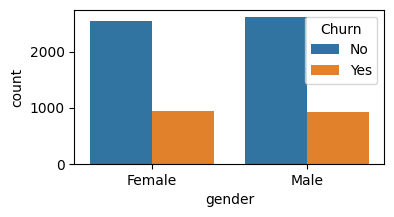

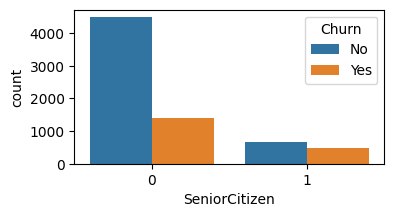

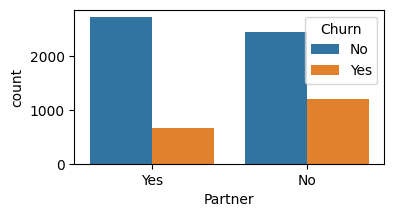

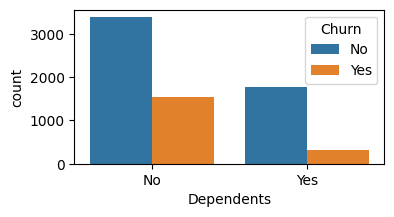

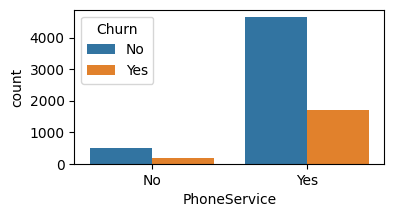

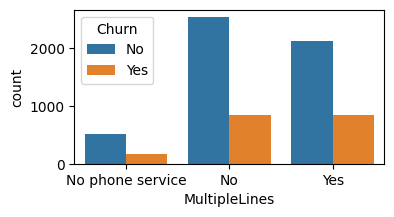

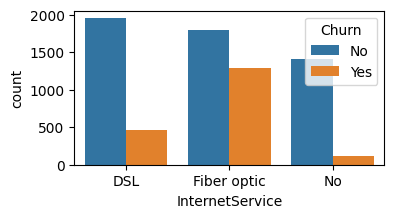

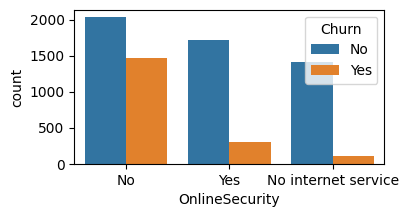

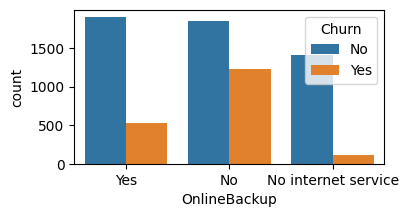

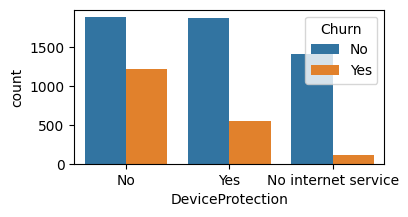

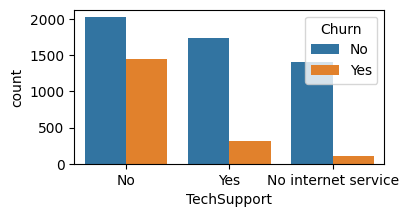

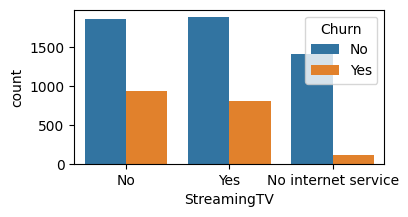

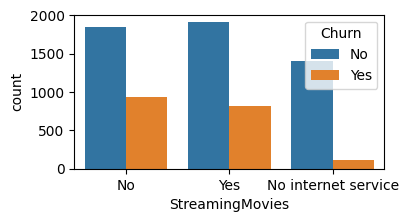

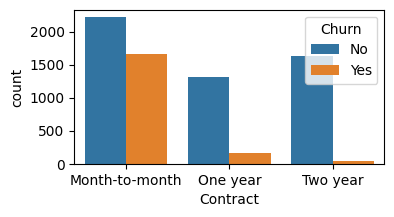

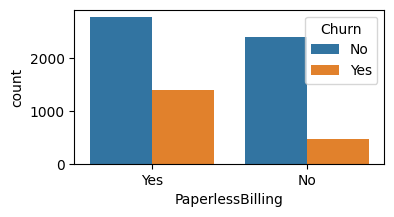

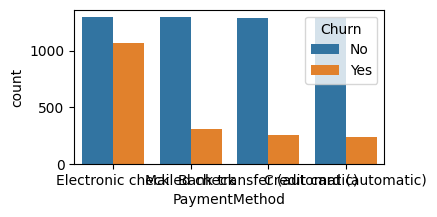

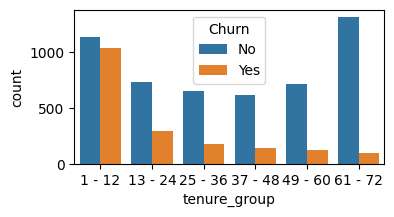

In [18]:
for i, predictor in enumerate(df.drop(columns=['Churn', 'TotalCharges', 'MonthlyCharges'])):
    plt.figure(figsize=(4, 2))  
    sns.countplot(data=df, x=predictor, hue='Churn')
    plt.show() 

Now, we see the effect of the numerical data ( monthly and total charges) on churn

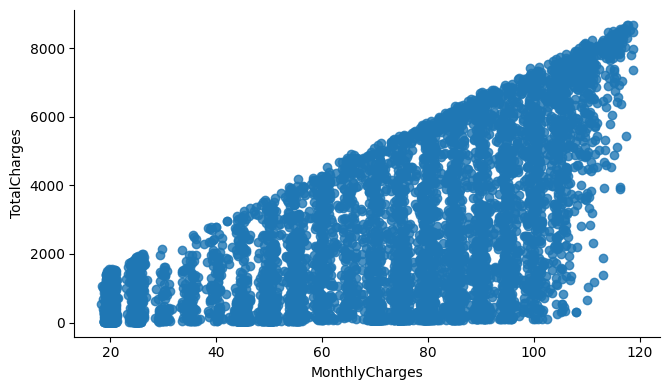

In [19]:
sns.lmplot(data=df, x='MonthlyCharges', y='TotalCharges', fit_reg=False, height=4, aspect=1.7)

Total charges increase as monthly charges increase - as expected

Now, we compare monthly charges and total charges for churned vs non-churned customers

C:\Users\asus\AppData\Local\Temp\ipykernel_19176\1336597341.py:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  Mth = sns.kdeplot(df.MonthlyCharges[(df["Churn"] == 'No') ],
C:\Users\asus\AppData\Local\Temp\ipykernel_19176\1336597341.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  Mth = sns.kdeplot(df.MonthlyCharges[(df["Churn"] == 'Yes') ],


Text(0.5, 1.0, 'Monthly charges by churn')

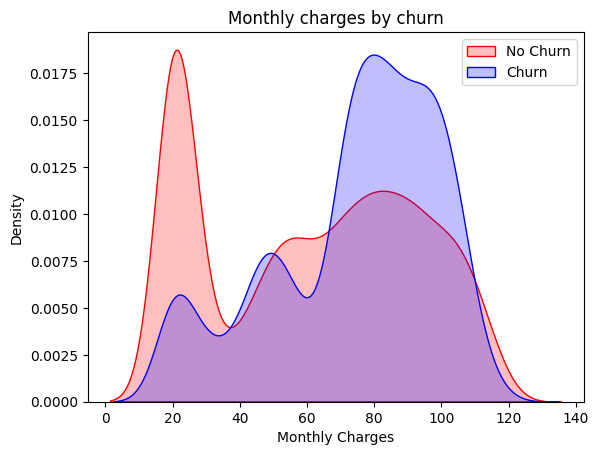

In [20]:
Mth = sns.kdeplot(df.MonthlyCharges[(df["Churn"] == 'No') ],
                color="Red", shade = True)
Mth = sns.kdeplot(df.MonthlyCharges[(df["Churn"] == 'Yes') ],
                ax =Mth, color="Blue", shade= True)
Mth.legend(["No Churn","Churn"],loc='upper right')
Mth.set_ylabel('Density')
Mth.set_xlabel('Monthly Charges')
Mth.set_title('Monthly charges by churn')

Churn is high when monthly charges are high

C:\Users\asus\AppData\Local\Temp\ipykernel_19176\3951183179.py:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  Mth = sns.kdeplot(df.TotalCharges[(df["Churn"] == 'No') ],
C:\Users\asus\AppData\Local\Temp\ipykernel_19176\3951183179.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  Mth = sns.kdeplot(df.TotalCharges[(df["Churn"] == 'Yes') ],


Text(0.5, 1.0, 'Total charges by churn')

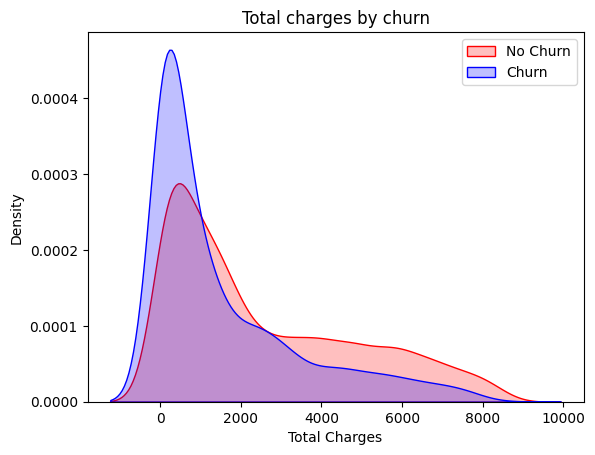

In [21]:
Mth = sns.kdeplot(df.TotalCharges[(df["Churn"] == 'No') ],
                color="Red", shade = True)
Mth = sns.kdeplot(df.TotalCharges[(df["Churn"] == 'Yes') ],
                ax =Mth, color="Blue", shade= True)
Mth.legend(["No Churn","Churn"],loc='upper right')
Mth.set_ylabel('Density')
Mth.set_xlabel('Total Charges')
Mth.set_title('Total charges by churn')

Here we note that there is high churn when the totalCharges are low

We can combine the insights from three parameters i.e. Tenure, Monthly Charges & Total Charges :- Higher Monthly Charge at lower tenure results into lower Total Charge. Hence, all these 3 factors viz **Higher Monthly Charge**,  **Lower tenure** and **Lower Total Charge** are linked to **High Churn**.

# Data-preprocessing

In this part , we will be preprocessing the dataset before building our model
1. Label Encoding of categorical features
2. Splitting datset into training and testing data
3. Handling imbalance (Using SMOTEENN, ADASYN)

Here, we will use label encoding which is suitable for tree models. 

Firstly, changing the target variable 'Churn' column. 

In [22]:
df["Churn"] = df["Churn"].replace({"Yes": 1, "No": 0})

C:\Users\asus\AppData\Local\Temp\ipykernel_19176\2364848822.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["Churn"] = df["Churn"].replace({"Yes": 1, "No": 0})


In [23]:
print(df["Churn"].value_counts())

Churn
0    5163
1    1869
Name: count, dtype: int64


Now, label encoding of categorical features

In [24]:
object_columns = df.select_dtypes(include="object").columns

In [25]:
for column in object_columns:
  label_encoder = LabelEncoder()
  df[column] = label_encoder.fit_transform(df[column])

In [26]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_group
0,0,0,1,0,0,1,0,0,2,0,0,0,0,0,1,2,29.85,29.85,0,1 - 12
1,1,0,0,0,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1889.50,0,25 - 36
2,1,0,0,0,1,0,0,2,2,0,0,0,0,0,1,3,53.85,108.15,1,1 - 12
3,1,0,0,0,0,1,0,2,0,2,2,0,0,1,0,0,42.30,1840.75,0,37 - 48
4,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65,1,1 - 12


In [27]:
print(df['tenure_group'].dtype)

category


In [28]:
df['tenure_group'] = df['tenure_group'].astype(str)
label_encoder = LabelEncoder()
df['tenure_group'] = label_encoder.fit_transform(df['tenure_group'])

In [29]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_group
0,0,0,1,0,0,1,0,0,2,0,0,0,0,0,1,2,29.85,29.85,0,0
1,1,0,0,0,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1889.50,0,2
2,1,0,0,0,1,0,0,2,2,0,0,0,0,0,1,3,53.85,108.15,1,0
3,1,0,0,0,0,1,0,2,0,2,2,0,0,1,0,0,42.30,1840.75,0,3
4,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65,1,0


<Axes: >

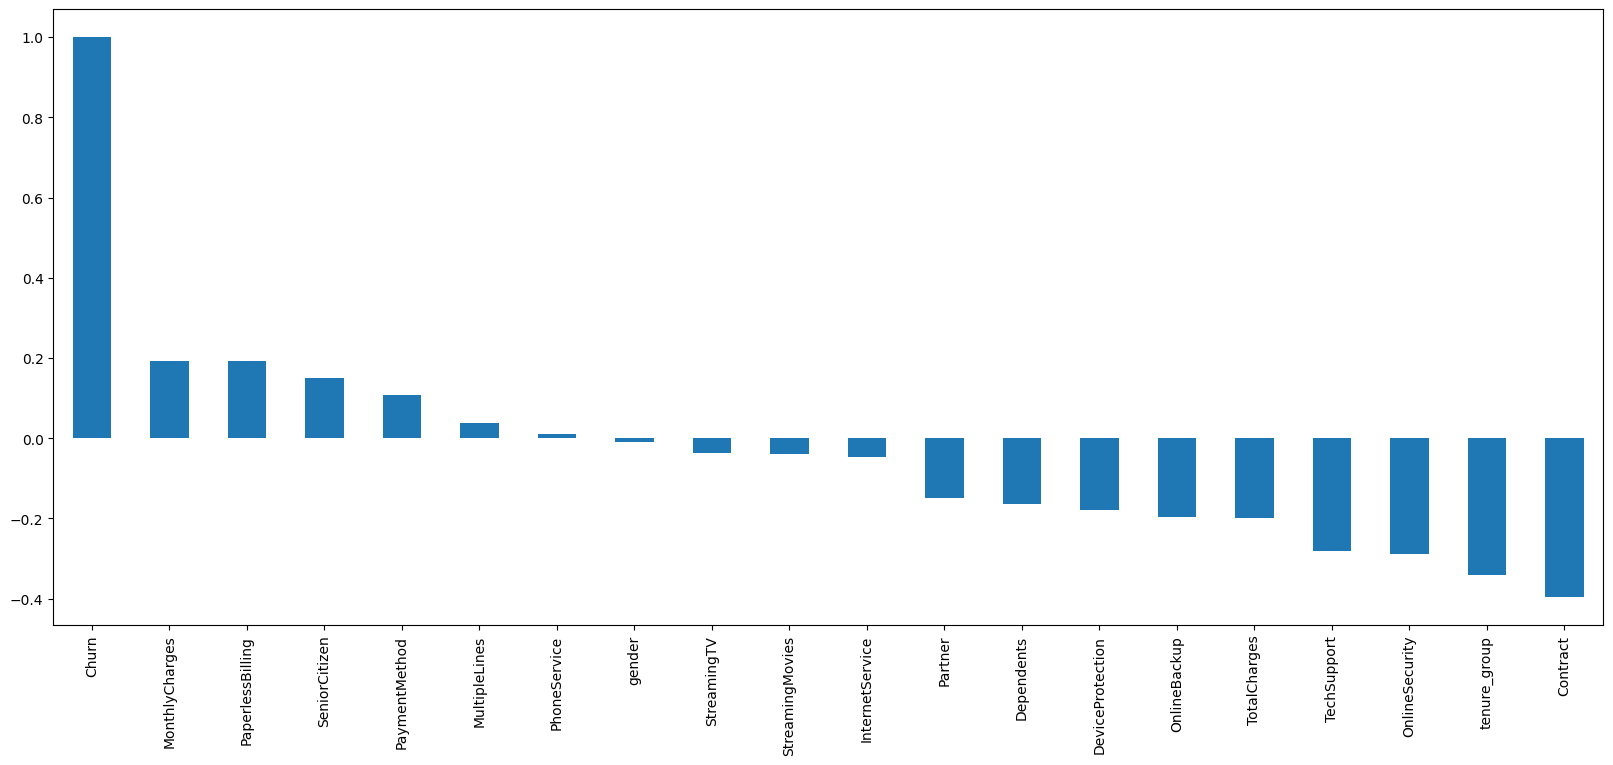

In [30]:
plt.figure(figsize=(20,8))
df.corr()['Churn'].sort_values(ascending = False).plot(kind='bar')

**High** churn is associated with **high monthly charges**, **paperless billing** and in **senior citizens**

**Low** churn is associated with **longer contract**, **long tenure**, **online security**, and **techsupport**

**gender** and **PhoneService** had more or less no impact on the churn  

<Axes: >

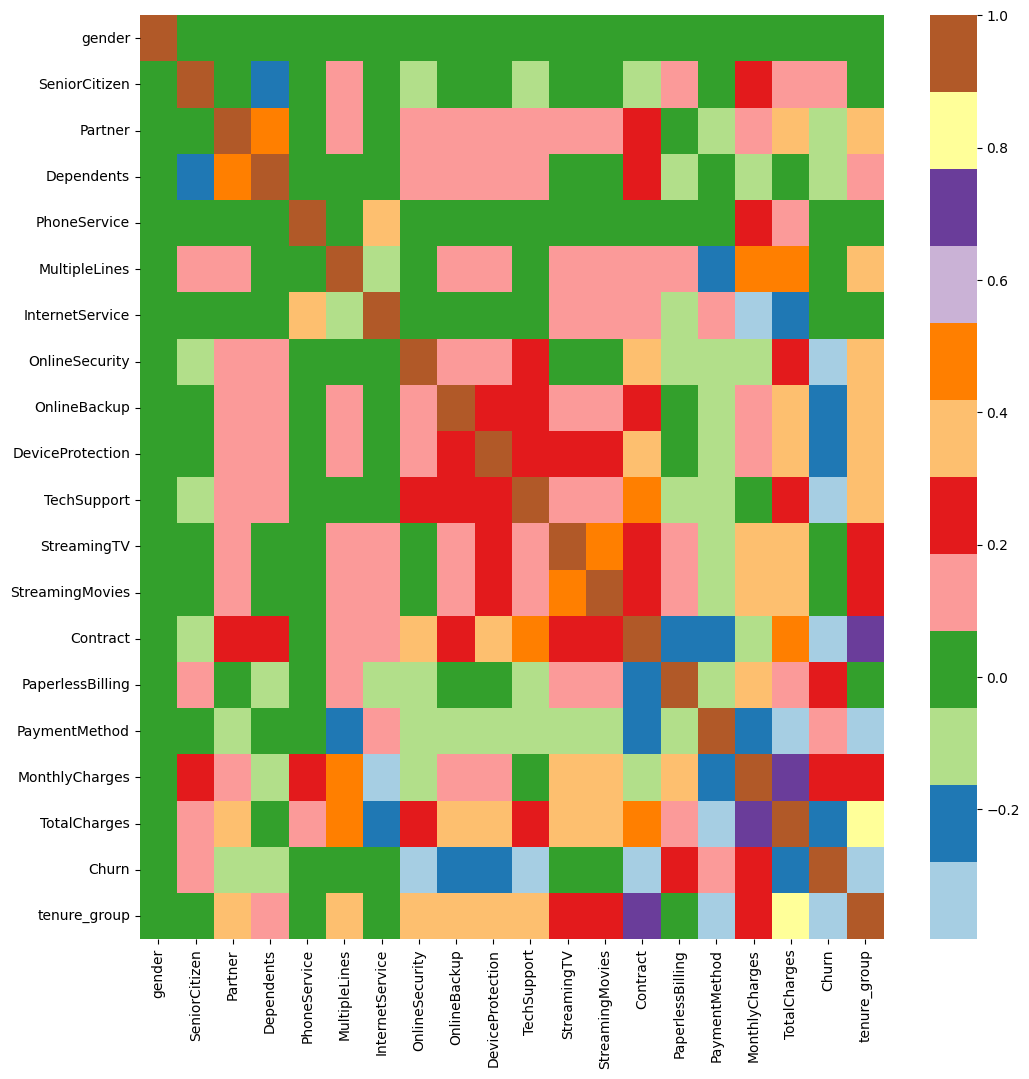

In [31]:
plt.figure(figsize=(12,12))
sns.heatmap(df.corr(), cmap="Paired")

Now, we split the data into training and testing

In [32]:
X = df.drop(columns=["Churn"])
y = df["Churn"]

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Applying SMOTE + ENN to handle the class imbalance

In [34]:
sm = SMOTEENN()
X_resampled, y_resampled = sm.fit_resample(X_train,y_train)

Applying ADASYN tohandle the class imbalance

In [35]:
ada=ADASYN()
X_resampled2, y_resampled2 = ada.fit_resample(X_train, y_train)

In [36]:
print(y_resampled.value_counts())

Churn
1    2572
0    2116
Name: count, dtype: int64


In [37]:
print(y_resampled2.value_counts())

Churn
1    4190
0    4130
Name: count, dtype: int64


# Model training and evaluation

Creating models for Random Forest, Decision trees and XG Boosting

In [38]:
dtc=DecisionTreeClassifier(random_state=42)
rfc=RandomForestClassifier(random_state=42)
xg=XGBClassifier(random_state=42)

In [39]:
## Without smoteenn or adasyn 

# Define models
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42)
}

# Perform Cross-Validation
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy') 
    print(f"\n===== {name} Cross-Validation Scores =====")
    print("Accuracy Scores:", scores)
    print("Mean Accuracy:", scores.mean())
    print("Standard Deviation:", scores.std())  



===== Decision Tree Cross-Validation Scores =====
Accuracy Scores: [0.72088889 0.75466667 0.72355556 0.73066667 0.72      ]
Mean Accuracy: 0.7299555555555555
Standard Deviation: 0.012910632999370905

===== Random Forest Cross-Validation Scores =====
Accuracy Scores: [0.79377778 0.78844444 0.78311111 0.79466667 0.80088889]
Mean Accuracy: 0.7921777777777776
Standard Deviation: 0.006012990053435655

===== XGBoost Cross-Validation Scores =====
Accuracy Scores: [0.79466667 0.79555556 0.76       0.78933333 0.78933333]
Mean Accuracy: 0.7857777777777779
Standard Deviation: 0.013148346373049307


In [40]:
# FOR SMOTENN
for name, model in models.items():
    scores = cross_val_score(model, X_resampled, y_resampled, cv=5, scoring='accuracy') 
    print(f"\n===== {name} Cross-Validation Scores =====")
    print("Accuracy Scores:", scores)
    print("Mean Accuracy:", scores.mean())
    print("Standard Deviation:", scores.std()) 


===== Decision Tree Cross-Validation Scores =====
Accuracy Scores: [0.89552239 0.93710021 0.93923241 0.94877268 0.95197439]
Mean Accuracy: 0.9345204151524736
Standard Deviation: 0.020285327175082694

===== Random Forest Cross-Validation Scores =====
Accuracy Scores: [0.92430704 0.95628998 0.96268657 0.95944504 0.95090715]
Mean Accuracy: 0.9507271539846126
Standard Deviation: 0.013769742863167012

===== XGBoost Cross-Validation Scores =====
Accuracy Scores: [0.92324094 0.95842217 0.96695096 0.96264674 0.9583778 ]
Mean Accuracy: 0.9539277237838858
Standard Deviation: 0.01566721475841929


In [41]:
# For ADASYN
for name, model in models.items():
    scores = cross_val_score(model, X_resampled2, y_resampled2, cv=5, scoring='accuracy') 
    print(f"\n===== {name} Cross-Validation Scores =====")
    print("Accuracy Scores:", scores)
    print("Mean Accuracy:", scores.mean())
    print("Standard Deviation:", scores.std()) 


===== Decision Tree Cross-Validation Scores =====
Accuracy Scores: [0.67608173 0.72475962 0.81850962 0.82692308 0.83533654]
Mean Accuracy: 0.7763221153846154
Standard Deviation: 0.06407771954440822

===== Random Forest Cross-Validation Scores =====
Accuracy Scores: [0.71814904 0.78425481 0.88701923 0.88581731 0.89963942]
Mean Accuracy: 0.8349759615384617
Standard Deviation: 0.07168803667586963

===== XGBoost Cross-Validation Scores =====
Accuracy Scores: [0.703125   0.79086538 0.88040865 0.88461538 0.90444712]
Mean Accuracy: 0.8326923076923076
Standard Deviation: 0.07570837041055561


Now, we finally test the models on our test data. 

NOTE that this will be an accurate measure of  the models performance since the test data is similar to real life data which has high class imbalance

**FOR SMOTEENN**

In [42]:

dtc.fit(X_resampled, y_resampled)
rfc.fit(X_resampled, y_resampled)
xg.fit(X_resampled, y_resampled)


y_pred_dtc = dtc.predict(X_test)
y_pred_rfc = rfc.predict(X_test)
y_pred_xgb = xg.predict(X_test)


print("===== Decision Tree Performance =====")
print("Accuracy:", accuracy_score(y_test, y_pred_dtc))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dtc))
print("Classification Report:\n", classification_report(y_test, y_pred_dtc))

print("\n===== Random Forest Performance =====")
print("Accuracy:", accuracy_score(y_test, y_pred_rfc))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rfc))
print("Classification Report:\n", classification_report(y_test, y_pred_rfc))

print("\n===== XGBoost Performance =====")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))


===== Decision Tree Performance =====
Accuracy: 0.7356076759061834
Confusion Matrix:
 [[775 258]
 [114 260]]
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.75      0.81      1033
           1       0.50      0.70      0.58       374

    accuracy                           0.74      1407
   macro avg       0.69      0.72      0.69      1407
weighted avg       0.77      0.74      0.75      1407


===== Random Forest Performance =====
Accuracy: 0.7512437810945274
Confusion Matrix:
 [[785 248]
 [102 272]]
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.76      0.82      1033
           1       0.52      0.73      0.61       374

    accuracy                           0.75      1407
   macro avg       0.70      0.74      0.71      1407
weighted avg       0.79      0.75      0.76      1407


===== XGBoost Performance =====
Accuracy: 0.7476901208244492
Confusion Matrix:

In [43]:
xg_params = {
    'n_estimators': np.arange(50, 500, 50),
    'max_depth': np.arange(3, 15, 2),
    'learning_rate': np.linspace(0.01, 0.3, 10),
    'subsample': np.linspace(0.5, 1, 5),
    'colsample_bytree': np.linspace(0.5, 1, 5), 
    'gamma': np.linspace(0, 5, 5),
    'reg_lambda': np.logspace(-2, 2, 5), 
    'reg_alpha': np.logspace(-2, 2, 5),  
    'min_child_weight': np.arange(1, 10, 2),  
    'scale_pos_weight': np.linspace(1, 10, 5)  }


xg_random = RandomizedSearchCV(xg, xg_params, n_iter=50, cv=5, scoring='f1', n_jobs=-1, random_state=42)
xg_random.fit(X_resampled, y_resampled)
best_xg = xg_random.best_estimator_


rfc_params = {
    'n_estimators': np.arange(50, 500, 50),
    'max_depth': np.arange(5, 30, 5),
    'min_samples_split': np.arange(2, 10, 2),
    'min_samples_leaf': np.arange(1, 10, 2),
    'max_features': ['sqrt', 'log2']
}

rfc_random = RandomizedSearchCV(rfc, rfc_params, n_iter=30, cv=5, scoring='f1', n_jobs=-1, random_state=42)
rfc_random.fit(X_resampled, y_resampled)
best_rfc = rfc_random.best_estimator_


print("Best XGBoost Parameters:", xg_random.best_params_)
print("Best Random Forest Parameters:", rfc_random.best_params_)


y_pred_xg = best_xg.predict(X_test)
y_pred_rfc = best_rfc.predict(X_test)

print("\n===== Tuned XGBoost Performance =====")
print("Accuracy:", accuracy_score(y_test, y_pred_xg))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xg))
print("Classification Report:\n", classification_report(y_test, y_pred_xg))

print("\n===== Tuned Random Forest Performance =====")
print("Accuracy:", accuracy_score(y_test, y_pred_rfc))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rfc))
print("Classification Report:\n", classification_report(y_test, y_pred_rfc))


Best XGBoost Parameters: {'subsample': np.float64(1.0), 'scale_pos_weight': np.float64(5.5), 'reg_lambda': np.float64(1.0), 'reg_alpha': np.float64(0.01), 'n_estimators': np.int64(300), 'min_child_weight': np.int64(1), 'max_depth': np.int64(11), 'learning_rate': np.float64(0.2677777777777778), 'gamma': np.float64(0.0), 'colsample_bytree': np.float64(0.5)}
Best Random Forest Parameters: {'n_estimators': np.int64(50), 'min_samples_split': np.int64(4), 'min_samples_leaf': np.int64(1), 'max_features': 'log2', 'max_depth': np.int64(15)}

===== Tuned XGBoost Performance =====
Accuracy: 0.7334754797441365
Confusion Matrix:
 [[757 276]
 [ 99 275]]
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.73      0.80      1033
           1       0.50      0.74      0.59       374

    accuracy                           0.73      1407
   macro avg       0.69      0.73      0.70      1407
weighted avg       0.78      0.73      0.75      1407




**For ADASYN**

In [44]:

dtc.fit(X_resampled2, y_resampled2)
rfc.fit(X_resampled2, y_resampled2)
xg.fit(X_resampled2, y_resampled2)

y_pred_dtc = dtc.predict(X_test)
y_pred_rfc = rfc.predict(X_test)
y_pred_xgb = xg.predict(X_test)

print("===== Decision Tree Performance =====")
print("Accuracy:", accuracy_score(y_test, y_pred_dtc))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dtc))
print("Classification Report:\n", classification_report(y_test, y_pred_dtc))

print("\n===== Random Forest Performance =====")
print("Accuracy:", accuracy_score(y_test, y_pred_rfc))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rfc))
print("Classification Report:\n", classification_report(y_test, y_pred_rfc))

print("\n===== XGBoost Performance =====")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))

===== Decision Tree Performance =====
Accuracy: 0.6986496090973703
Confusion Matrix:
 [[792 241]
 [183 191]]
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.77      0.79      1033
           1       0.44      0.51      0.47       374

    accuracy                           0.70      1407
   macro avg       0.63      0.64      0.63      1407
weighted avg       0.71      0.70      0.71      1407


===== Random Forest Performance =====
Accuracy: 0.7533759772565742
Confusion Matrix:
 [[854 179]
 [168 206]]
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.83      0.83      1033
           1       0.54      0.55      0.54       374

    accuracy                           0.75      1407
   macro avg       0.69      0.69      0.69      1407
weighted avg       0.76      0.75      0.75      1407


===== XGBoost Performance =====
Accuracy: 0.7455579246624022
Confusion Matrix:

In [45]:
xg_params = {
    'n_estimators': np.arange(50, 500, 50),
    'max_depth': np.arange(3, 15, 2),
    'learning_rate': np.linspace(0.01, 0.3, 10),
    'subsample': np.linspace(0.5, 1, 5),
    'colsample_bytree': np.linspace(0.5, 1, 5), 
    'gamma': np.linspace(0, 5, 5),
    'reg_lambda': np.logspace(-2, 2, 5),  
    'reg_alpha': np.logspace(-2, 2, 5),  
    'min_child_weight': np.arange(1, 10, 2),  
    'scale_pos_weight': np.linspace(1, 10, 5) 
}

xg_random = RandomizedSearchCV(xg, xg_params, n_iter=50, cv=5, scoring='f1', n_jobs=-1, random_state=42)
xg_random.fit(X_resampled2, y_resampled2)
best_xg = xg_random.best_estimator_

rfc_params = {
    'n_estimators': np.arange(50, 500, 50),
    'max_depth': np.arange(5, 30, 5),
    'min_samples_split': np.arange(2, 10, 2),
    'min_samples_leaf': np.arange(1, 10, 2),
    'max_features': ['sqrt', 'log2']
}

rfc_random = RandomizedSearchCV(rfc, rfc_params, n_iter=30, cv=5, scoring='f1', n_jobs=-1, random_state=42)
rfc_random.fit(X_resampled2, y_resampled2)
best_rfc = rfc_random.best_estimator_


print("Best XGBoost Parameters:", xg_random.best_params_)
print("Best Random Forest Parameters:", rfc_random.best_params_)


y_pred_xg = best_xg.predict(X_test)
y_pred_rfc = best_rfc.predict(X_test)

print("\n===== Tuned XGBoost Performance =====")
print("Accuracy:", accuracy_score(y_test, y_pred_xg))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xg))
print("Classification Report:\n", classification_report(y_test, y_pred_xg))

print("\n===== Tuned Random Forest Performance =====")
print("Accuracy:", accuracy_score(y_test, y_pred_rfc))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rfc))
print("Classification Report:\n", classification_report(y_test, y_pred_rfc))



Best XGBoost Parameters: {'subsample': np.float64(1.0), 'scale_pos_weight': np.float64(5.5), 'reg_lambda': np.float64(1.0), 'reg_alpha': np.float64(0.01), 'n_estimators': np.int64(300), 'min_child_weight': np.int64(1), 'max_depth': np.int64(11), 'learning_rate': np.float64(0.2677777777777778), 'gamma': np.float64(0.0), 'colsample_bytree': np.float64(0.5)}
Best Random Forest Parameters: {'n_estimators': np.int64(100), 'min_samples_split': np.int64(2), 'min_samples_leaf': np.int64(1), 'max_features': 'log2', 'max_depth': np.int64(15)}

===== Tuned XGBoost Performance =====
Accuracy: 0.7313432835820896
Confusion Matrix:
 [[806 227]
 [151 223]]
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.78      0.81      1033
           1       0.50      0.60      0.54       374

    accuracy                           0.73      1407
   macro avg       0.67      0.69      0.68      1407
weighted avg       0.75      0.73      0.74      1407



We note the following key changes:
1. Random forest has proved to be the best model among the three. (slightly better than xgboost)
2. There's a tradeoff between using ADASYN and SMOTEENN : 

ADASYN -- Better accuracy , minimizes **false positives** ( Customers predicted as churners but actually stayed)

SMOTEENN -- Better F1 score, Minimizes **false negatives** (Customers who actually churned but were predicted as non-churners)


Better model depends on the business requirements:

a. If **retention efforts are expensive**, **ADAYSN** proves to be a better model.

b. If the **goal is to reduce customer churn**, **SMOTEENN** is a better choice.

# Saving and loading the model

Now, we will save the model for future reference

In [46]:
model_data = {"model": best_rfc, "features_names": X.columns.tolist()}


with open("churn_model.pkl", "wb") as f:
  pickle.dump(model_data, f)

In [47]:
with open("churn_model.pkl", "rb") as f:
  model_data = pickle.load(f)

loaded_model = model_data["model"]
feature_names = model_data["features_names"]

In [48]:
print(loaded_model)

RandomForestClassifier(max_depth=np.int64(15), max_features='log2',
                       min_samples_leaf=np.int64(1),
                       min_samples_split=np.int64(2),
                       n_estimators=np.int64(100), random_state=42)


In [49]:
print(feature_names)

['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'tenure_group']
